# Threshold for $F_1$ score calculation

---

## 1. Load Tensors and Targets

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from common import *

%matplotlib inline

bottleneck_features = np.load('data/bottleneck_features/yelp_resnet50_50k.npz')

X_train = bottleneck_features['train_features'].reshape(50000,2048)
X_valid = bottleneck_features['valid_features'].reshape(5000,2048)
X_test  = bottleneck_features['test_features'].reshape(5000,2048)

y_train = bottleneck_features['train_targets']
y_valid = bottleneck_features['valid_targets']
y_test  = bottleneck_features['test_targets']

Using TensorFlow backend.


## 2. Features scaling

In [2]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)

del X_train, X_valid, X_test

## 3. Principal Component Analysis

In [3]:
from sklearn.decomposition import PCA
n_comp = 200
pca = PCA(n_components=n_comp, svd_solver='randomized', whiten=True)
pca.fit(X_train_scaled)

X_train_reduced = pca.transform(X_train_scaled)
X_valid_reduced = pca.transform(X_valid_scaled)
X_test_reduced = pca.transform(X_test_scaled)

del X_train_scaled, X_valid_scaled, X_test_scaled

## 4. Parameters of the Test

In [4]:
size_train = 1000
bins_train = range(0, 50000, size_train)

size_valid = size_train//10
bins_valid = range(0, 5000, size_valid)
bins_test = bins_valid

threshold = [x/100. for x in range(25,75,5)]

## 5. Classification with XGBoost

In [5]:
import xgboost as xgb

param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.015
param['max_depth'] = 10
param['subsample'] = 0.5
param['eval_metric'] = 'logloss'
param['colsample_bytree'] = 0.3
param['nthread'] = 4

num_round = 500

y_hat = np.array([[0]*9]*(size_valid), dtype=np.float32)
f1_scores_ovr = np.array([[0]*len(bins_train)]*len(threshold), dtype=np.float32)

for s in range(0,len(bins_train)):
    for l in range(9):
        xg_train = xgb.DMatrix(X_train_reduced[bins_train[s]:bins_train[s]+size_train], 
                               label=y_train[bins_train[s]:bins_train[s]+size_train,l])
        xg_valid = xgb.DMatrix(X_valid_reduced[bins_valid[s]:bins_valid[s]+size_valid], 
                               label=y_valid[bins_valid[s]:bins_valid[s]+size_valid,l])
        xg_test = xgb.DMatrix(X_test_reduced[bins_test[s]:bins_test[s]+size_valid], 
                              label=y_test[bins_test[s]:bins_test[s]+size_valid,l])

        eval_list = [(xg_train, 'train'),(xg_valid, 'valid')]
        model = xgb.train(param, xg_train, num_round, eval_list, verbose_eval=False, 
                          early_stopping_rounds=10)

        y_hat[:,l] = model.predict(xg_test)
    
    
    f1_scores_ovr[:,s] = [f1_score(y_test[bins_test[s]:bins_test[s]+size_valid,:], (y_hat >= t).astype(int)) 
                          for t in threshold]
    print("Sample %d/%d: F1 score =" % (s, len(bins_train)), f1_scores_ovr[:,s])

del xg_train, xg_valid, xg_test

Sample 0/50: F1 score = [ 0.73724294  0.73831773  0.74285716  0.74233639  0.75813544  0.72527474
  0.67192787  0.63912517  0.6177215   0.57104194]
Sample 1/50: F1 score = [ 0.73554355  0.74763405  0.75613749  0.7482993   0.72841728  0.6978637
  0.66591424  0.63885576  0.60253167  0.55675673]
Sample 2/50: F1 score = [ 0.69875777  0.70458138  0.70910555  0.71367884  0.70909089  0.68535823
  0.63768119  0.58115184  0.53277546  0.48882264]
Sample 3/50: F1 score = [ 0.67534584  0.68802696  0.70035464  0.70883721  0.70923382  0.71003306
  0.67661691  0.65327978  0.58536583  0.52093023]
Sample 4/50: F1 score = [ 0.69490194  0.70129871  0.70487595  0.71276593  0.70919323  0.67012447
  0.63403261  0.58397931  0.52840906  0.43710691]
Sample 5/50: F1 score = [ 0.74051124  0.7505976   0.75165564  0.7452668   0.72827083  0.69486403
  0.66146994  0.6102941   0.55153948  0.47482014]
Sample 6/50: F1 score = [ 0.73853213  0.75078863  0.75020611  0.75106204  0.75709218  0.72997034
  0.66972476  0.593516

## 6. Results

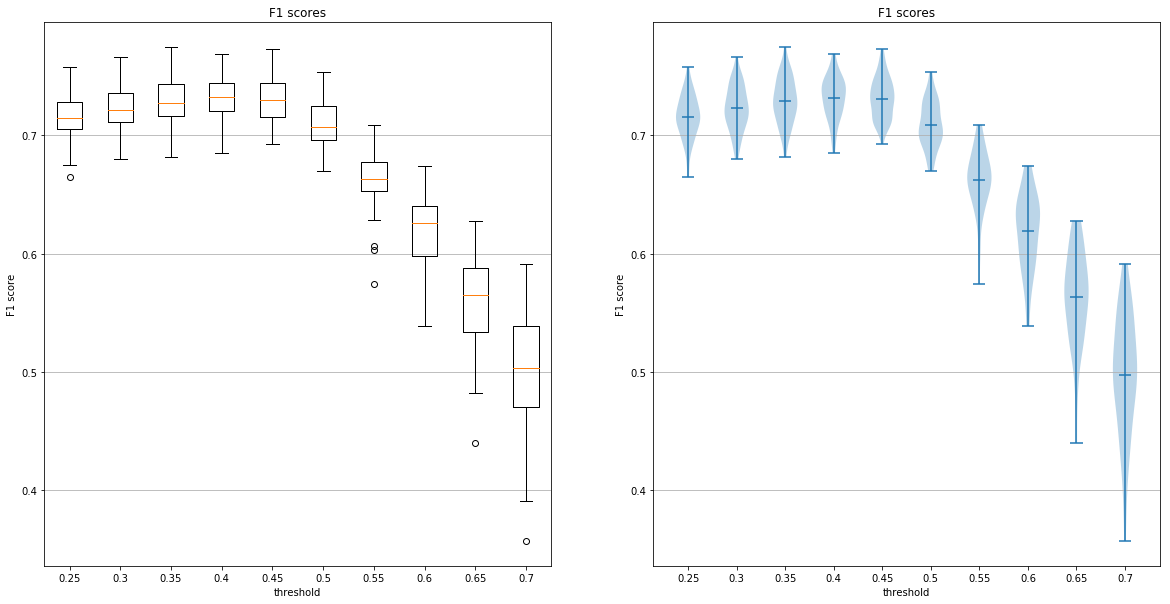

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# box plot
axes[0].boxplot(list(f1_scores_ovr))
axes[0].set_title('F1 scores')

# violin plot
axes[1].violinplot(list(f1_scores_ovr), showmeans=True, showmedians=False)
axes[1].set_title('F1 scores')

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(threshold))])
    ax.set_xlabel('threshold')
    ax.set_ylabel('F1 score')
    ax.set_xticklabels(map(str,threshold))
    

# add x-tick labels
plt.setp(axes, xticks=[y+1 for y in range(len(threshold))])#, xticklabels=map(str,threshold))
plt.show()